# Setup Details

Location: Ashpark Primary School, Glasgow

Dataset used: BEACON and OpenWeatherMap - MERGED

Weather variables used: temp, pressure, humidity, windspeed

# Libraries and Dependencies

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# CO2 x Weather (Merged) - Ashpark Primary School

Start: 3/12/2022 4:00

End: 7/4/2024 1:00

NOTE: The weather location is Glasgow

In [2]:
# Loading datasets
co2_filepath = 'Dataset/Ashpark Primary School.csv'
weather_filepath = 'Dataset/filtered_weather_data.csv'

In [3]:
co2_df = pd.read_csv(co2_filepath)
weather_df = pd.read_csv(weather_filepath)

In [4]:
co2_df.head(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,o3_ppm_QC_level,PM_2.5_ug/m3,PM_2.5_ug/m3_QC_level
0,2022-03-12 04:00:00,2022-03-12 12:00:00,176,1.647086e+09,71.500000,-999.0,NaN,432.8,1a,-999,NaN,0.5,2
1,2022-03-12 05:00:00,2022-03-12 13:00:00,176,1.647090e+09,71.541667,-999.0,NaN,435.2,1a,-999,NaN,1.6,2


In [5]:
weather_df.head(2)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1609434000,2020-12-31 17:00:00,0,Glasgow,55.86167,-4.258335,3.83,9999.0,1.71,-0.18,...,0.0,0.11,NaN,NaN,NaN,20,500,Rain,light rain,10n
1,1609437600,2020-12-31 18:00:00,0,Glasgow,55.86167,-4.258335,4.48,9999.0,1.16,0.36,...,0.0,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n


## Merging Datasets - CO2 x Weather
Merging the datasets based on common timestamp

In [6]:
# Converting timestamp to datetime objects
co2_df['local_timestamp'] = pd.to_datetime(co2_df['local_timestamp'])
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'])

In [7]:
# Merging datasets on the datetime column
merged_data = pd.merge(co2_df, weather_df, left_on='local_timestamp', right_on='dt_iso', how='inner') # how='inner' makes sure only timestamps present in both datasets are merged

In [8]:
# Merged dataset
merged_data.head(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2022-03-12 04:00:00,2022-03-12 12:00:00,176,1.647086e+09,71.500000,-999.0,NaN,432.8,1a,-999,...,NaN,0.20,NaN,NaN,NaN,94,500,Rain,light rain,10n
1,2022-03-12 05:00:00,2022-03-12 13:00:00,176,1.647090e+09,71.541667,-999.0,NaN,435.2,1a,-999,...,NaN,0.36,NaN,NaN,NaN,75,500,Rain,light rain,10n


In [9]:
merged_data.tail(2)

,local_timestamp,datetime,node_id,epoch,julian_day,co_ppm,co_ppm_QC_level,co2_ppm,co2_ppm_QC_level,o3_ppm,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
6736,2024-01-31 02:00:00,2024-01-31 10:00:00,176,1.706695e+09,31.416667,-999.0,2.0,435.3,1a,-999,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
6737,2024-01-31 03:00:00,2024-01-31 11:00:00,176,1.706699e+09,31.458333,-999.0,2.0,435.1,1a,-999,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


41 columns. Need cleaning and dropping of irrelevant data

## Data Cleaning

In [10]:
# Selecting the required columns only
merged_updated_df = merged_data[['local_timestamp', 'co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']]

In [11]:
merged_updated_df.head(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
0,2022-03-12 04:00:00,432.8,7.70,997,89,2.57
1,2022-03-12 05:00:00,435.2,7.57,997,88,4.12


In [12]:
merged_updated_df.tail(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
6736,2024-01-31 02:00:00,435.3,6.26,1024,81,10.29
6737,2024-01-31 03:00:00,435.1,6.48,1023,82,9.26


In [13]:
merged_updated_df.count()

local_timestamp    6738
co2_ppm            6738
temp               6738
pressure           6738
humidity           6738
wind_speed         6738
dtype: int64

In [14]:
# Dropping rows with missing values
## Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
merged_cleaned_df = merged_updated_df.dropna()

In [15]:
merged_cleaned_df.count()

local_timestamp    6738
co2_ppm            6738
temp               6738
pressure           6738
humidity           6738
wind_speed         6738
dtype: int64

In [16]:
# Handling duplicate data
merged_cleaned_df = merged_cleaned_df.drop_duplicates()

In [17]:
# Checking cleaned data
missing_values_after = merged_cleaned_df.isnull().sum()
print("Missing values after cleaning:\n", missing_values_after)

Missing values after cleaning:
 local_timestamp    0
co2_ppm            0
temp               0
pressure           0
humidity           0
wind_speed         0
dtype: int64


In [18]:
# Removing rows where co2 values are -999
invalid_values = [-999]
merged_cleaned_df = merged_cleaned_df[~merged_cleaned_df['co2_ppm'].isin(invalid_values)]

## Data Analysis

In [19]:
merged_cleaned_df.describe()

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
count,6628,6628.000000,6628.000000,6628.000000,6628.000000,6628.000000
mean,2023-02-13 00:45:09.233554432,443.384113,9.560015,1011.452625,82.496379,4.529956
min,2022-03-12 04:00:00,407.100000,-5.230000,968.000000,36.000000,0.000000
25%,2022-05-20 05:45:00,428.300000,6.240000,1004.000000,78.000000,2.060000
50%,2022-07-28 06:30:00,435.300000,9.860000,1013.000000,85.000000,4.120000
75%,2023-11-23 01:15:00,445.300000,13.130000,1020.000000,90.000000,6.170000
max,2024-01-31 03:00:00,652.700000,29.790000,1045.000000,100.000000,25.720000
std,NaN,28.826686,5.058415,13.590189,9.963756,2.893985


In [20]:
merged_cleaned_df.head(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
0,2022-03-12 04:00:00,432.8,7.70,997,89,2.57
1,2022-03-12 05:00:00,435.2,7.57,997,88,4.12


In [21]:
merged_cleaned_df.tail(2)

,local_timestamp,co2_ppm,temp,pressure,humidity,wind_speed
6736,2024-01-31 02:00:00,435.3,6.26,1024,81,10.29
6737,2024-01-31 03:00:00,435.1,6.48,1023,82,9.26


### Time-Series Analysis

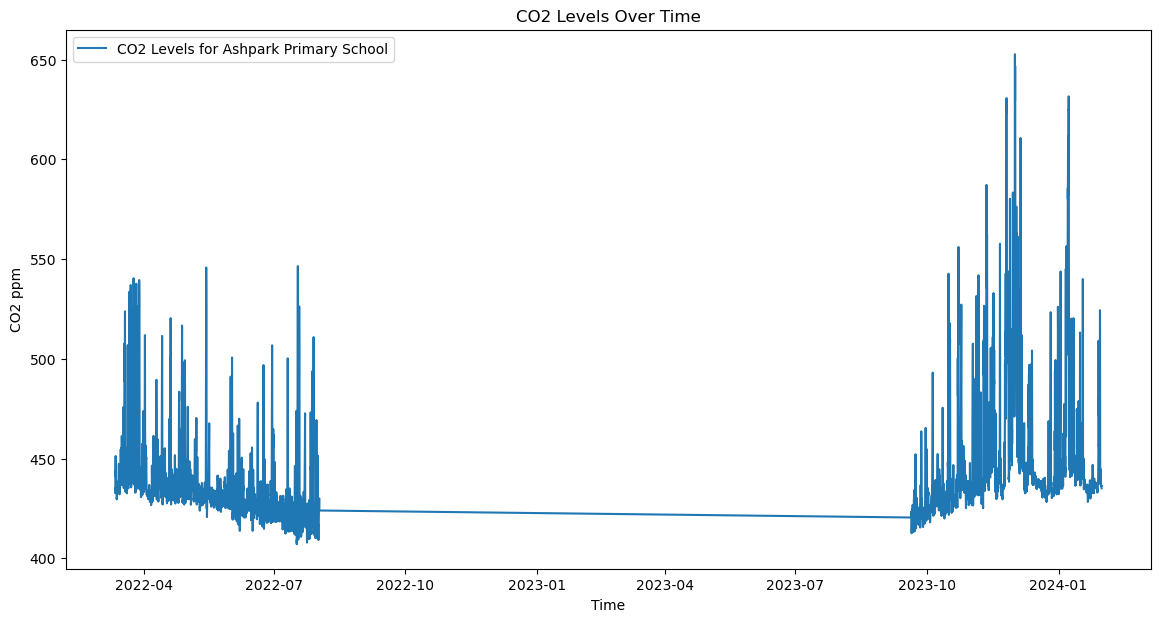

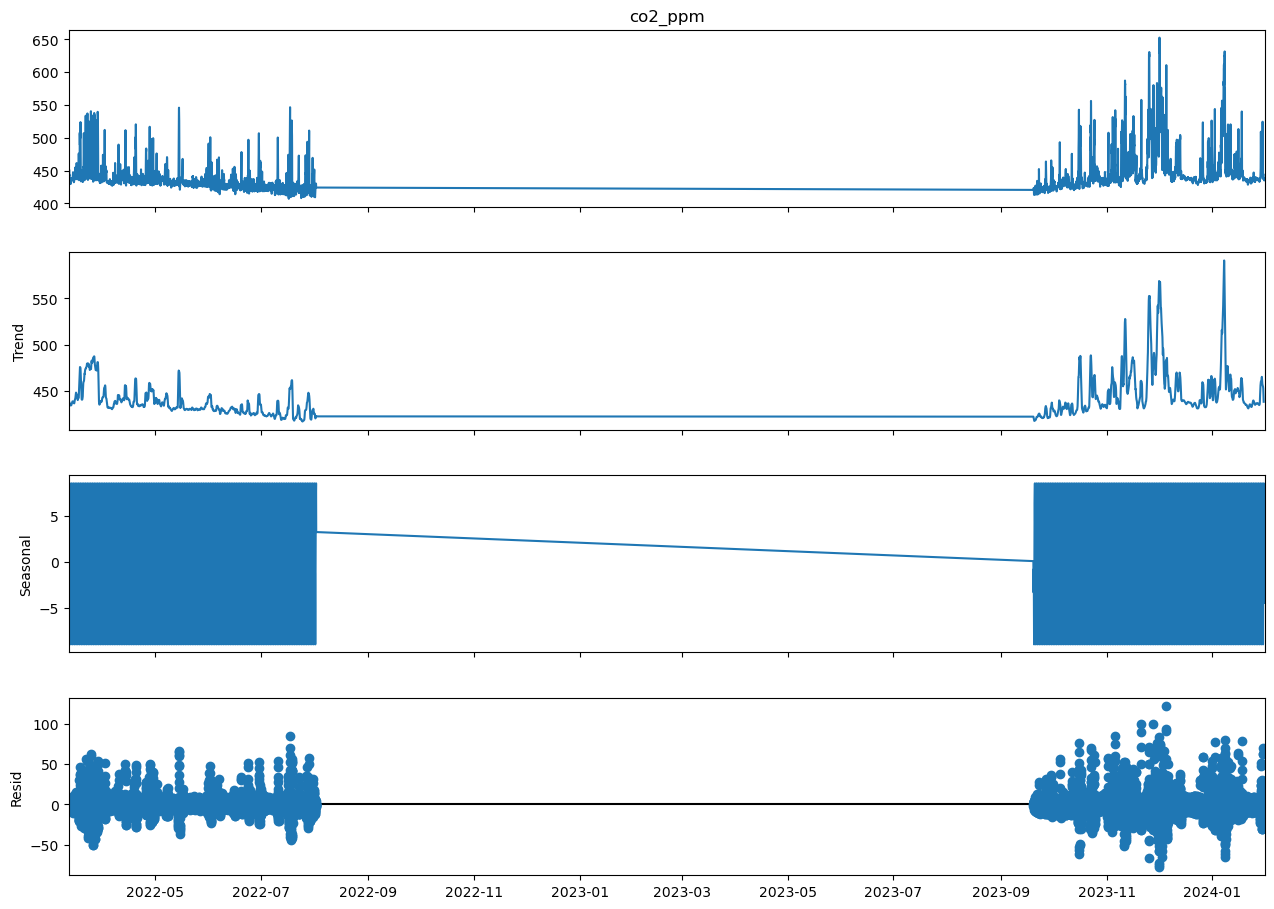

In [22]:
# Plotting CO2 levels over time
plt.figure(figsize=(14, 7))
plt.plot(merged_cleaned_df['local_timestamp'], merged_cleaned_df['co2_ppm'], label='CO2 Levels for Ashpark Primary School')
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('CO2 Levels Over Time')
plt.legend()
plt.show()

# Time series decomposition
decomposition = sm.tsa.seasonal_decompose(merged_cleaned_df.set_index('local_timestamp')['co2_ppm'], model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### Correlation Analysis

Reference: https://www.geeksforgeeks.org/how-to-calculate-autocorrelation-in-python/

#### Correlation Matrix

In [23]:
# Correlation matrix
correlation_matrix = merged_cleaned_df[['co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']].corr()
print(correlation_matrix)

             co2_ppm      temp  pressure  humidity  wind_speed
co2_ppm     1.000000 -0.448581  0.112157  0.118268   -0.339439
temp       -0.448581  1.000000  0.082090 -0.503269    0.300845
pressure    0.112157  0.082090  1.000000 -0.281670   -0.237428
humidity    0.118268 -0.503269 -0.281670  1.000000   -0.166255
wind_speed -0.339439  0.300845 -0.237428 -0.166255    1.000000


#### Scatter Plots

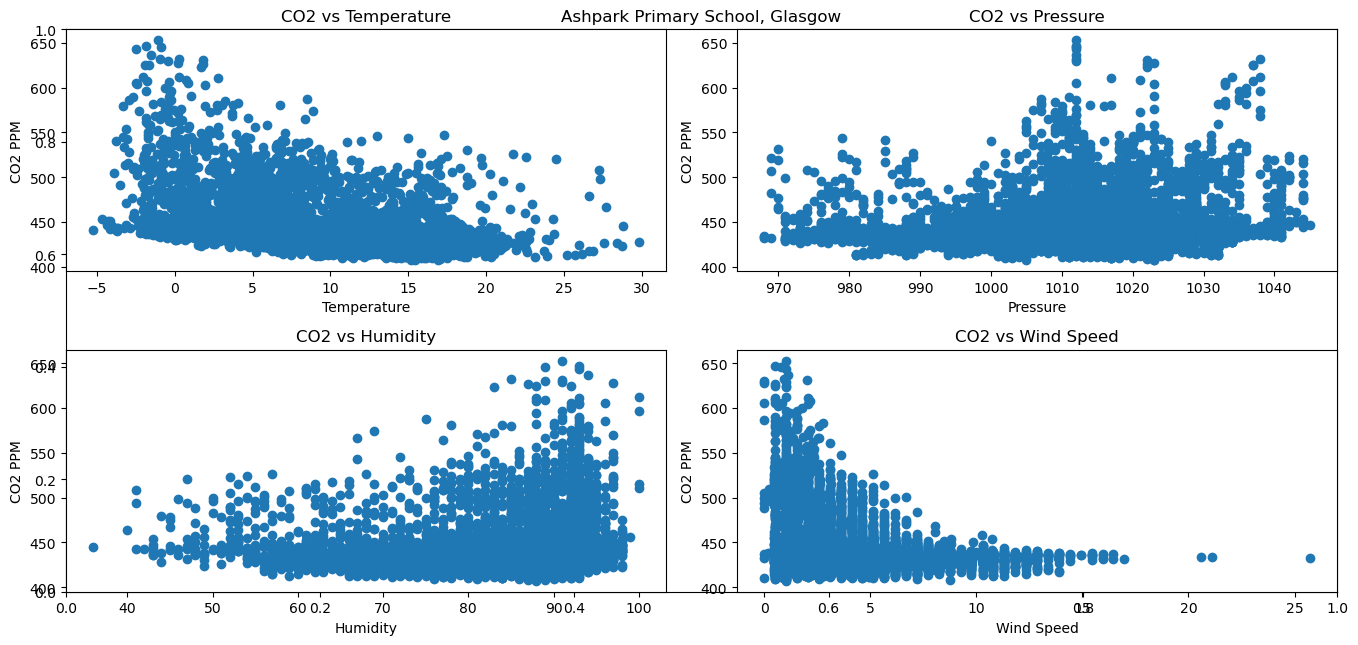

In [24]:
# Scatter plots
plt.figure(figsize=(14, 7))
plt.title("Ashpark Primary School, Glasgow")

plt.subplot(2, 2, 1)
plt.scatter(merged_cleaned_df['temp'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Temperature')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Temperature')

plt.subplot(2, 2, 2)
plt.scatter(merged_cleaned_df['pressure'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Pressure')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Pressure')

plt.subplot(2, 2, 3)
plt.scatter(merged_cleaned_df['humidity'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Humidity')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Humidity')

plt.subplot(2, 2, 4)
plt.scatter(merged_cleaned_df['wind_speed'], merged_cleaned_df['co2_ppm'])
plt.xlabel('Wind Speed')
plt.ylabel('CO2 PPM')
plt.title('CO2 vs Wind Speed')

plt.tight_layout()
plt.show()

There appears to be a slight trend where higher wind speeds are associated with lower CO2 concentrations. It suggests that wind speed might have a slight impact on dispersing CO2, leading to lower concentrations at higher wind speeds.

#### Correlation Heatmap

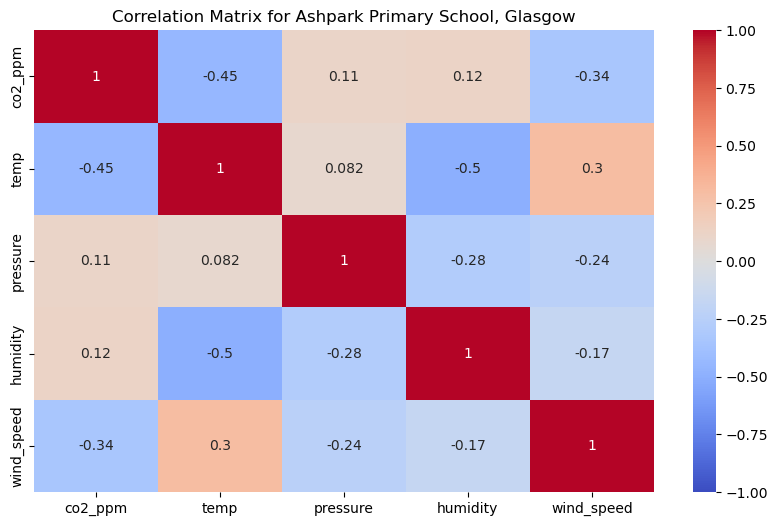

In [25]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Ashpark Primary School, Glasgow')
plt.show()

#### Lag Plot

In [26]:
# Preparing data

# Extracting the CO2 values from the merged dataset
co2_data = merged_cleaned_df[['local_timestamp', 'co2_ppm']]

# Ensuring the timestamp is the index
co2_data.set_index('local_timestamp', inplace=True)

# Displaying top 15 data
co2_data.head(15)

,co2_ppm
local_timestamp,
2022-03-12 04:00:00,432.8
2022-03-12 05:00:00,435.2
2022-03-12 06:00:00,435.3
2022-03-12 07:00:00,434.3
2022-03-12 08:00:00,433.6
2022-03-12 09:00:00,436.8
2022-03-12 10:00:00,443.2
2022-03-12 11:00:00,451.3
2022-03-12 12:00:00,441.2


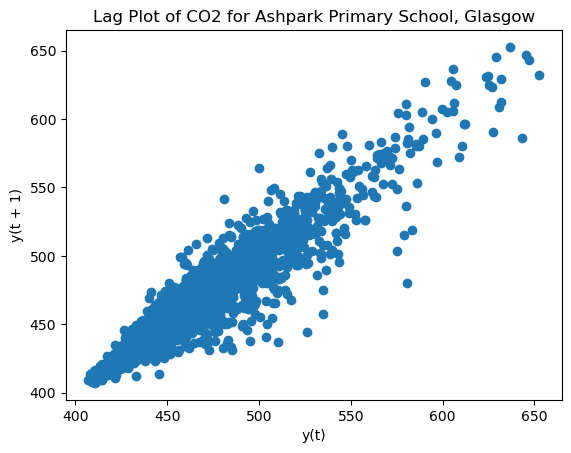

In [27]:
# Plotting the lag plot
pd.plotting.lag_plot(co2_data, lag=1)
plt.title('Lag Plot of CO2 for Ashpark Primary School, Glasgow')
plt.show()

#### Auto correlation Plot

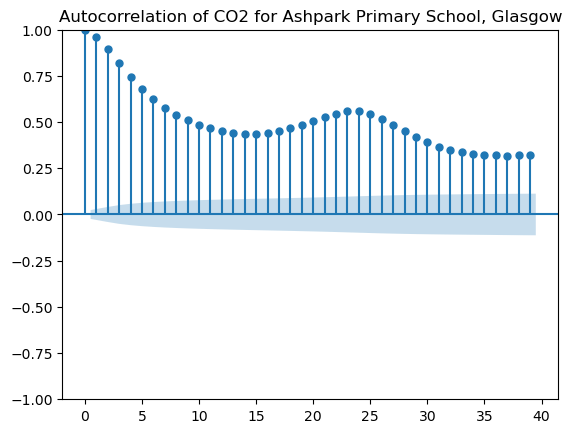

In [28]:
# Plotting the autocorrelation function
plot_acf(co2_data)
plt.title('Autocorrelation of CO2 for Ashpark Primary School, Glasgow')
plt.show()

#### Lagged Data and Correlation Matrix

In [29]:
# Creating lagged dataset for correlation computation
values = pd.DataFrame(co2_data.values)
dataframe = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
dataframe.columns = ['t-3', 't-2', 't-1', 't']

# Computing the correlation matrix
result = dataframe.corr()
print(result)

          t-3       t-2       t-1         t
t-3  1.000000  0.961095  0.893185  0.817475
t-2  0.961095  1.000000  0.961096  0.893186
t-1  0.893185  0.961096  1.000000  0.961096
t    0.817475  0.893186  0.961096  1.000000


### Distribution Plots

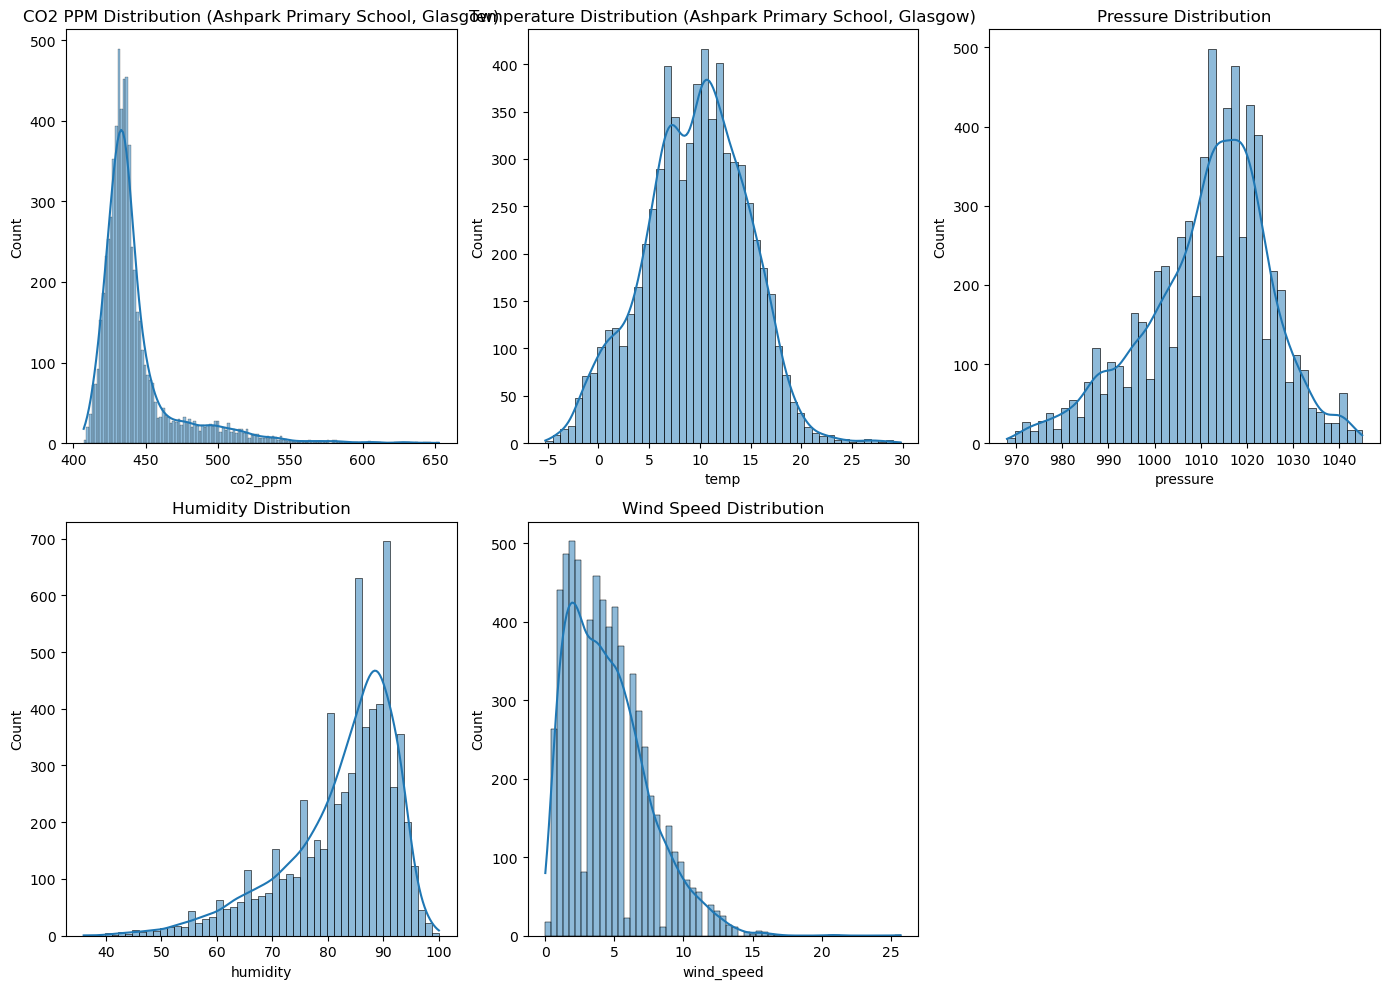

In [30]:
# Distribution plots
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
sns.histplot(merged_cleaned_df['co2_ppm'], kde=True)
plt.title('CO2 PPM Distribution (Ashpark Primary School, Glasgow)')

plt.subplot(2, 3, 2)
sns.histplot(merged_cleaned_df['temp'], kde=True)
plt.title('Temperature Distribution (Ashpark Primary School, Glasgow)')

plt.subplot(2, 3, 3)
sns.histplot(merged_cleaned_df['pressure'], kde=True)
plt.title('Pressure Distribution')

plt.subplot(2, 3, 4)
sns.histplot(merged_cleaned_df['humidity'], kde=True)
plt.title('Humidity Distribution')

plt.subplot(2, 3, 5)
sns.histplot(merged_cleaned_df['wind_speed'], kde=True)
plt.title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

### Box Plots

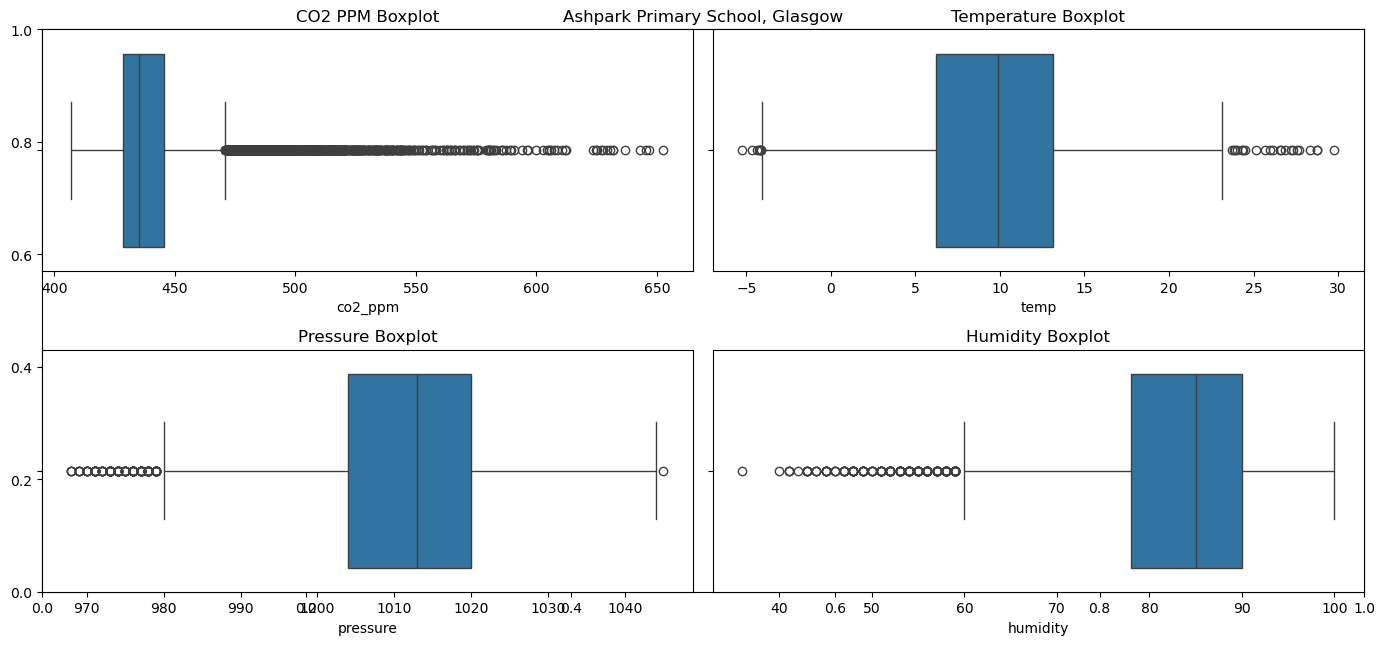

In [31]:
# Boxplots
plt.figure(figsize=(14, 7))
plt.title("Ashpark Primary School, Glasgow")

plt.subplot(2, 2, 1)
sns.boxplot(x=merged_cleaned_df['co2_ppm'])
plt.title('CO2 PPM Boxplot')

plt.subplot(2, 2, 2)
sns.boxplot(x=merged_cleaned_df['temp'])
plt.title('Temperature Boxplot')

plt.subplot(2, 2, 3)
sns.boxplot(x=merged_cleaned_df['pressure'])
plt.title('Pressure Boxplot')

plt.subplot(2, 2, 4)
sns.boxplot(x=merged_cleaned_df['humidity'])
plt.title('Humidity Boxplot')

plt.tight_layout()
plt.show()

### Rolling Mean

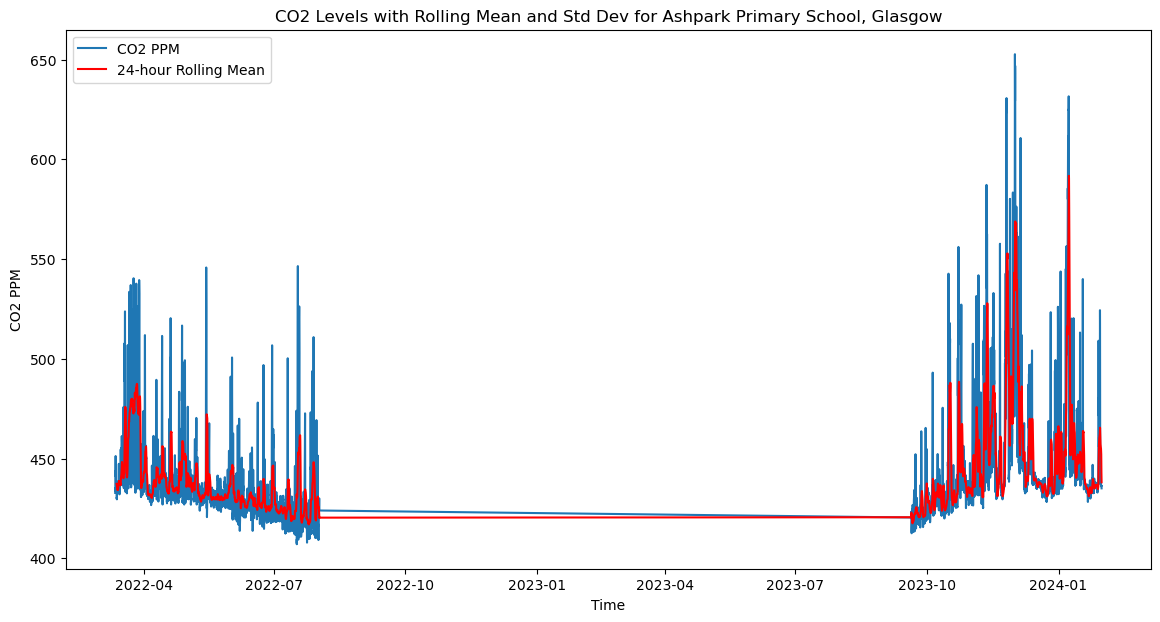

In [32]:
# Rolling mean and standard deviation
rolling_mean = merged_cleaned_df['co2_ppm'].rolling(window=24).mean() # Averaging 24 hour window
rolling_std = merged_cleaned_df['co2_ppm'].rolling(window=24).std()

plt.figure(figsize=(14, 7))
plt.plot(merged_cleaned_df['local_timestamp'], merged_cleaned_df['co2_ppm'], label='CO2 PPM')
plt.plot(merged_cleaned_df['local_timestamp'], rolling_mean, color='red', label='24-hour Rolling Mean')
plt.xlabel('Time')
plt.ylabel('CO2 PPM')
plt.title('CO2 Levels with Rolling Mean and Std Dev for Ashpark Primary School, Glasgow')
plt.legend()
plt.show()


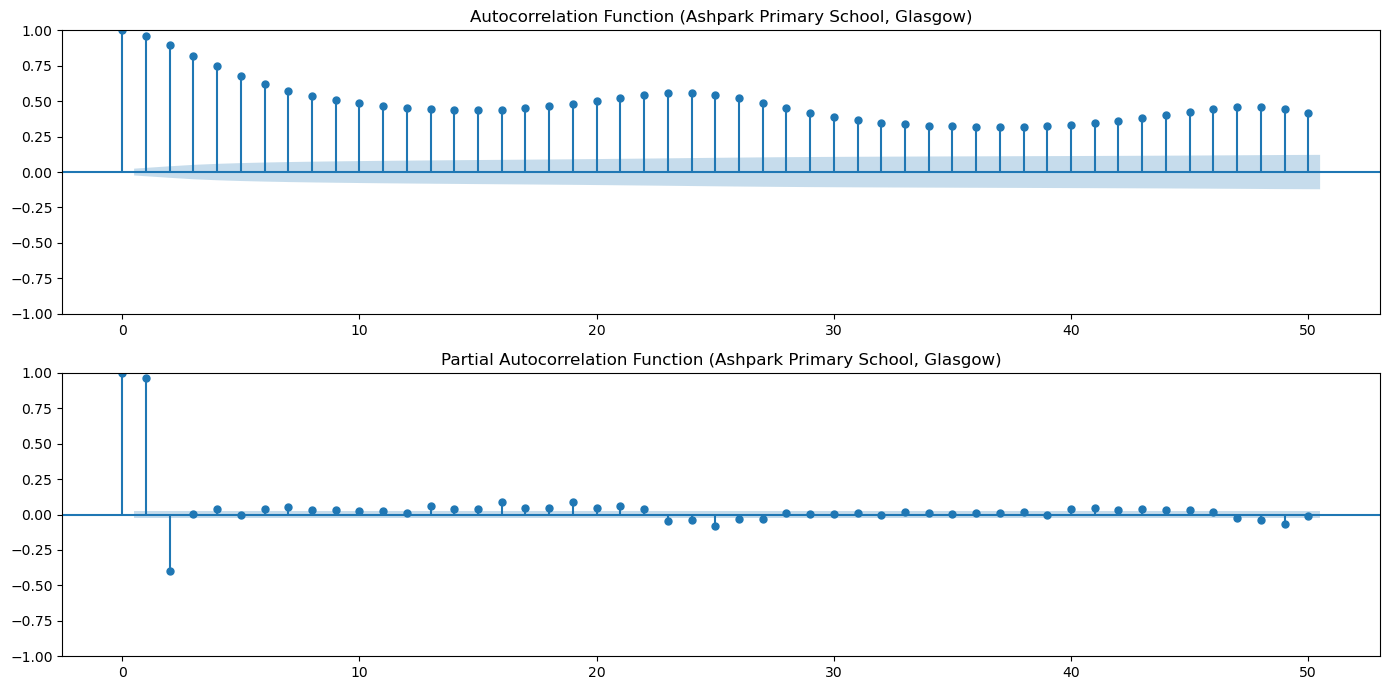

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(merged_cleaned_df['co2_ppm'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (Ashpark Primary School, Glasgow)')

plt.subplot(2, 1, 2)
plot_pacf(merged_cleaned_df['co2_ppm'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (Ashpark Primary School, Glasgow)')

plt.tight_layout()
plt.show()

# Modelling 

### Preprocessing for LSTM

In [34]:
# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
# Converting the DataFrame to a NumPy array
merged_data = merged_cleaned_df[['co2_ppm', 'temp', 'pressure', 'humidity', 'wind_speed']].values

In [36]:
# Normalizing the data to a fixed range
scaler = MinMaxScaler() ## to range [0,1]
merged_data_scaled = scaler.fit_transform(merged_data)

In [37]:
window_size = 48 ## Window_size of 48 means past 2 days are used to predict the next hour

In [38]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size, 0])  # Predicting the next CO2 value. '0' indicates the first column (co2) which is the target value
    return np.array(sequences), np.array(labels)

### Splitting

In [39]:
# Create sequences (X) and labels (y)
X, y = create_sequences(merged_data_scaled, window_size)

#Splitting the data into train and temporary sets (80% train, 20% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)

# Splitting the temporary data into validation and test sets (50% each of the temporary set)
# This results in 80% train, 10% validation, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshaping the data to be compatible with LSTM input (samples, window_size, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2])) ## .shape[2] (3rd element) used to ensure that the number of features dimension is dynamically captured
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Checking the shape of the data
print("X_train shape:", X_train.shape)  # Should be (num_samples, window_size, num_features)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5264, 48, 5)
X_val shape: (658, 48, 5)
X_test shape: (658, 48, 5)
y_train shape: (5264,)
y_val shape: (658,)
y_test shape: (658,)


In [40]:
# Checks
print("X_train length:", len(X_train))
print("y_train length:", len(y_train))
print("X type:", (type(X)))

X_train length: 5264
y_train length: 5264
X type: <class 'numpy.ndarray'>


In [41]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) ## Stops training if the validation loss does not improve for 4 consecutive epochs.
## Restores the model weights to the best epoch where the validation loss was lowest.

## LSTM

In [42]:
# One LSTM Layer Architecture
model1 = Sequential()
model1.add(LSTM(50, return_sequences=False, input_shape=(window_size, merged_data_scaled.shape[1])))  # 50 units
model1.add(Dense(1))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Save the initial weights for Model 1
initial_weights_model1 = model1.get_weights()

# Reset the model to its initial state before training 
model1.set_weights(initial_weights_model1)

In [44]:
# Compiling the model
model1.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Training the model
history_model1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]) ## verbose=1: Progress bar. Displays a progress bar for each epoch.

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0164 - val_loss: 0.0030
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 9.6722e-04
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 9.0493e-04
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 8.8146e-04
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8619e-04 - val_loss: 8.7411e-04
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4704e-04 - val_loss: 8.6829e-04
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1671e-04 - val_loss: 8.6296e-04
Epoch 12/20
165/

In [46]:
# Extracting loss values 
train_loss_1 = history_model1.history['loss']
val_loss_1 = history_model1.history['val_loss']

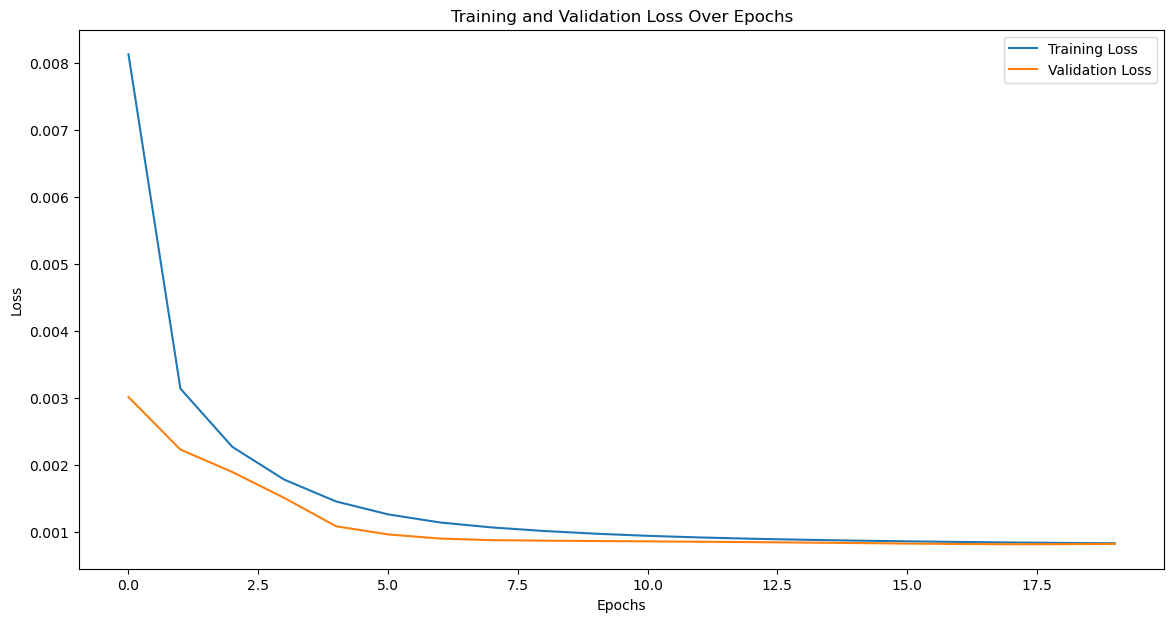

In [47]:
# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_1, label='Training Loss')
plt.plot(val_loss_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [48]:
# Evaluating the model on the test set
test_loss_1 = model1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_1}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017     
Test Loss: 0.0013311735820025206


In [49]:
# Making predictions on the test set
y_pred_1 = model1.predict(X_test)

# Inverse transforming predictions and actual values to their original scale
y_pred_inv_1 = scaler.inverse_transform(np.concatenate((y_pred_1, np.zeros((y_pred_1.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test_inv_1 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Evaluation

In [50]:
# Calculate evaluation metrics
mse_1 = mean_squared_error(y_test_inv_1, y_pred_inv_1)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test_inv_1, y_pred_inv_1)
mae_1 = mean_absolute_error(y_test_inv_1, y_pred_inv_1)

print(f'Mean Squared Error (MSE): {mse_1}')
print(f'Root Mean Squared Error (RMSE): {rmse_1}')
print(f'R-squared (R^2): {r2_1}')
print(f'Mean Absolute Error (MAE): {mae_1}')

Mean Squared Error (MSE): 80.29555279441566
Root Mean Squared Error (RMSE): 8.960778581932246
R-squared (R^2): 0.9352200591791712
Mean Absolute Error (MAE): 5.297395992156783


#### Plots

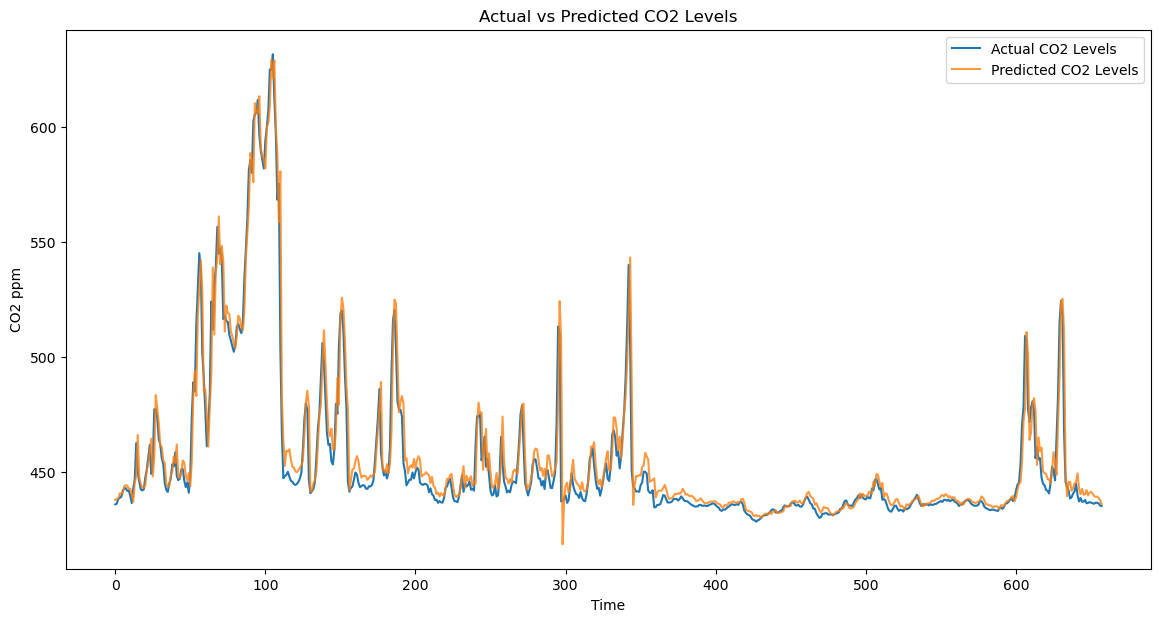

In [51]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_1, label='Actual CO2 Levels')
plt.plot(y_pred_inv_1, label='Predicted CO2 Levels', alpha = 0.8) # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

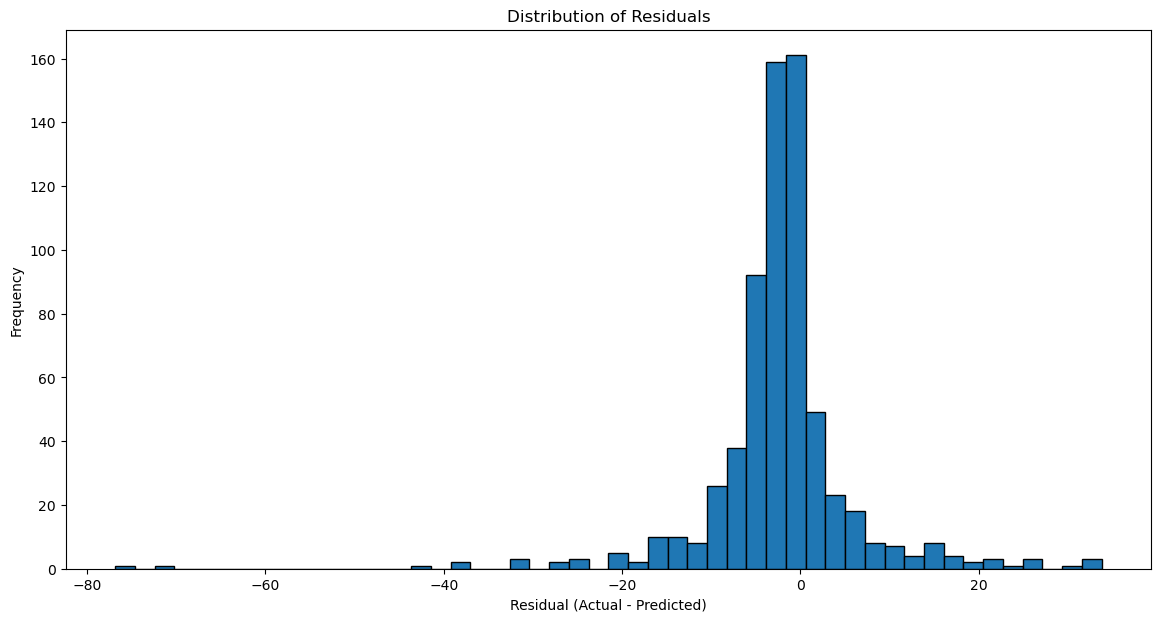

In [52]:
# Plotting residuals
residuals_1 = y_test_inv_1 - y_pred_inv_1
plt.figure(figsize=(14, 7))
plt.hist(residuals_1, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

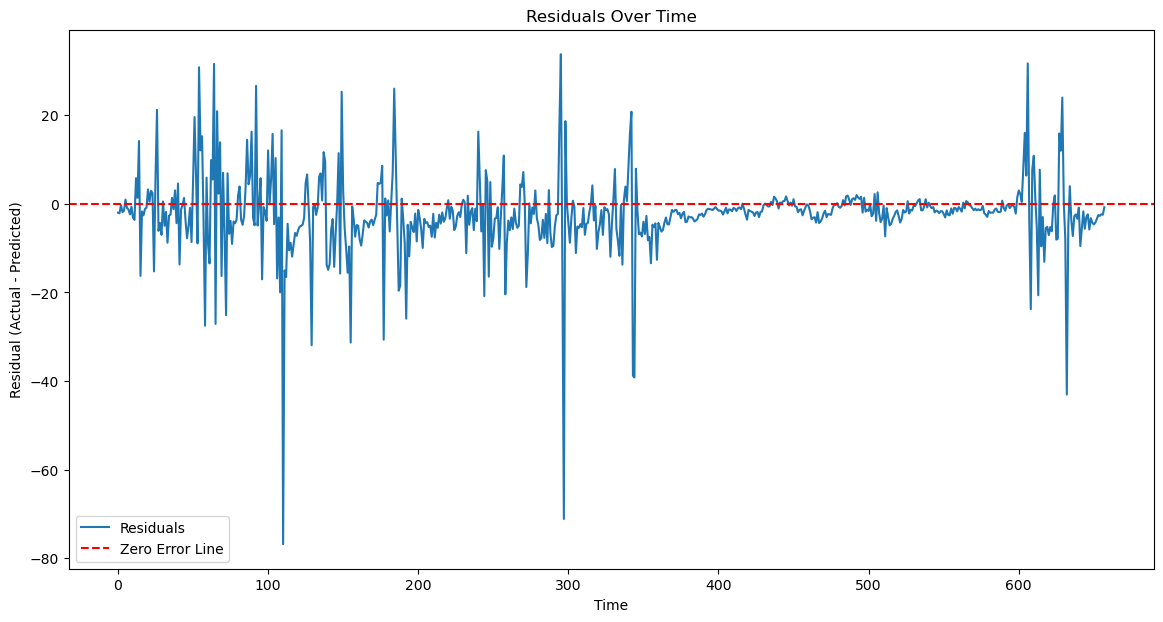

In [53]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_1, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()


## 2nd LSTM
2 LSTM layers and 64 units per layer

In [54]:
# LSTM architecture
model2 = Sequential()
# First LSTM layer
model2.add(LSTM(50, return_sequences=True, input_shape=(window_size, merged_data_scaled.shape[1])))
model2.add(Dropout(0.2)) # Dropout layer. 20% of the neurons are randomly dropped during training to prevent overfitting
# Second LSTM layer
model2.add(LSTM(50)) # No return_sequences as this is the last layer
model2.add(Dropout(0.2))
# Dense layer
model2.add(Dense(1)) ## output layer, with a single neuron, as we are predicting a single continuous value (the CO2 level)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Save the initial weights for Model 2
initial_weights_model2 = model2.get_weights()

# Reset the model to its initial state before training 
model2.set_weights(initial_weights_model2)

In [56]:
# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 48, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Training the model
history_model2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]) ## verbose=1: Progress bar. Displays a progress bar for each epoch.

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0126 - val_loss: 0.0035
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0033 - val_loss: 0.0018


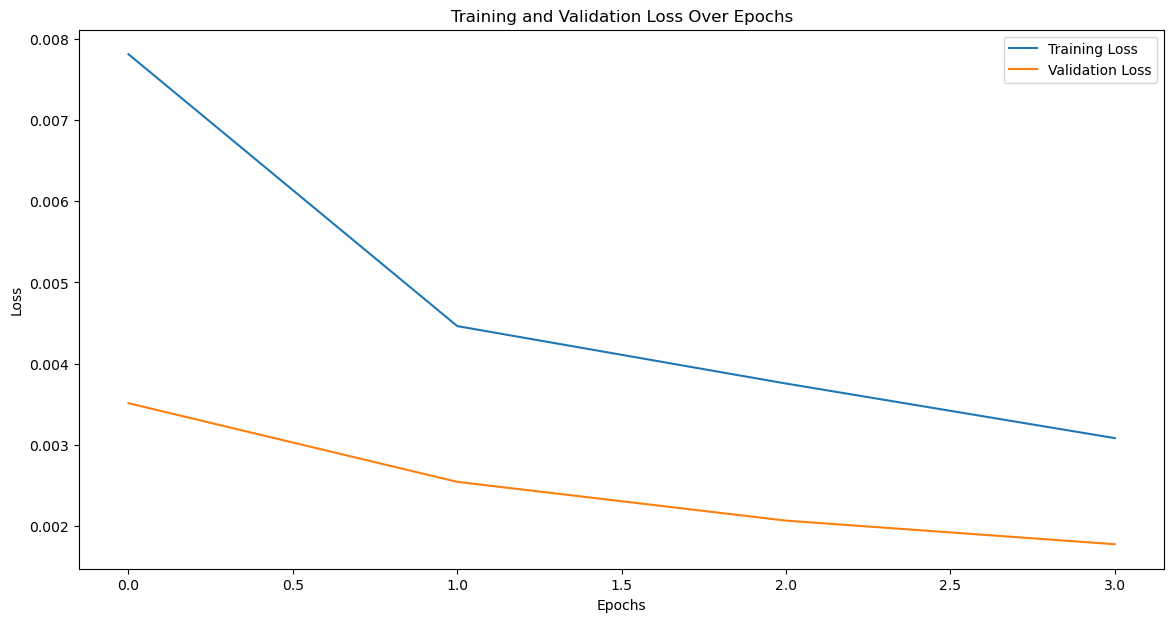

In [58]:
# Extracting loss values 
train_loss_2 = history_model2.history['loss']
val_loss_2 = history_model2.history['val_loss']

# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_2, label='Training Loss')
plt.plot(val_loss_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [59]:
# Evaluate the model on the test set
test_loss_2 = model2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_2}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Test Loss: 0.008189939893782139


In [60]:
# Make predictions on the test set
y_pred_2 = model2.predict(X_test)

# Inverse transform predictions and actual values to their original scale
y_pred_inv_2 = scaler.inverse_transform(
    np.concatenate(
        (y_pred_2, np.zeros((y_pred_2.shape[0], merged_data_scaled.shape[1] - 1))), axis=1
    )
)[:, 0]
y_test_inv_2 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


### Evaluation

In [61]:
# Calculate evaluation metrics
mse_2 = mean_squared_error(y_test_inv_2, y_pred_inv_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test_inv_2, y_pred_inv_2)
mae_2 = mean_absolute_error(y_test_inv_2, y_pred_inv_2)

print(f'Mean Squared Error (MSE): {mse_2}')
print(f'Root Mean Squared Error (RMSE): {rmse_2}')
print(f'R-squared (R^2): {r2_2}')
print(f'Mean Absolute Error (MAE): {mae_2}')

Mean Squared Error (MSE): 494.0119208378507
Root Mean Squared Error (RMSE): 22.226378941200718
R-squared (R^2): 0.6014466320619739
Mean Absolute Error (MAE): 15.900699632888893


#### Plots

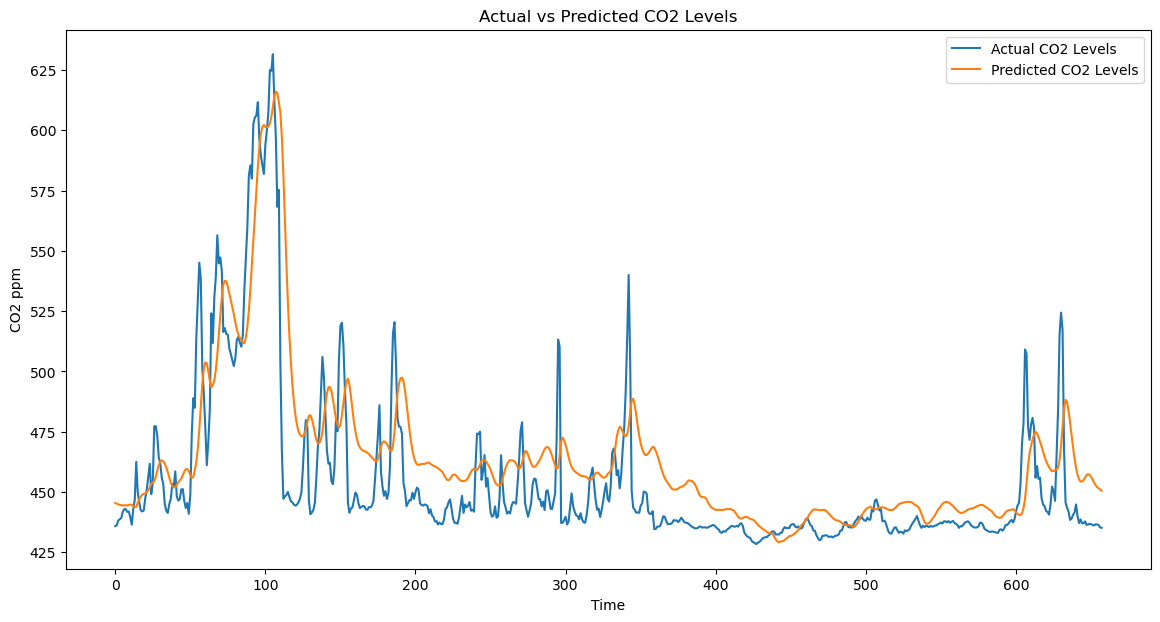

In [62]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_2, label='Actual CO2 Levels')
plt.plot(y_pred_inv_2, label='Predicted CO2 Levels') # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

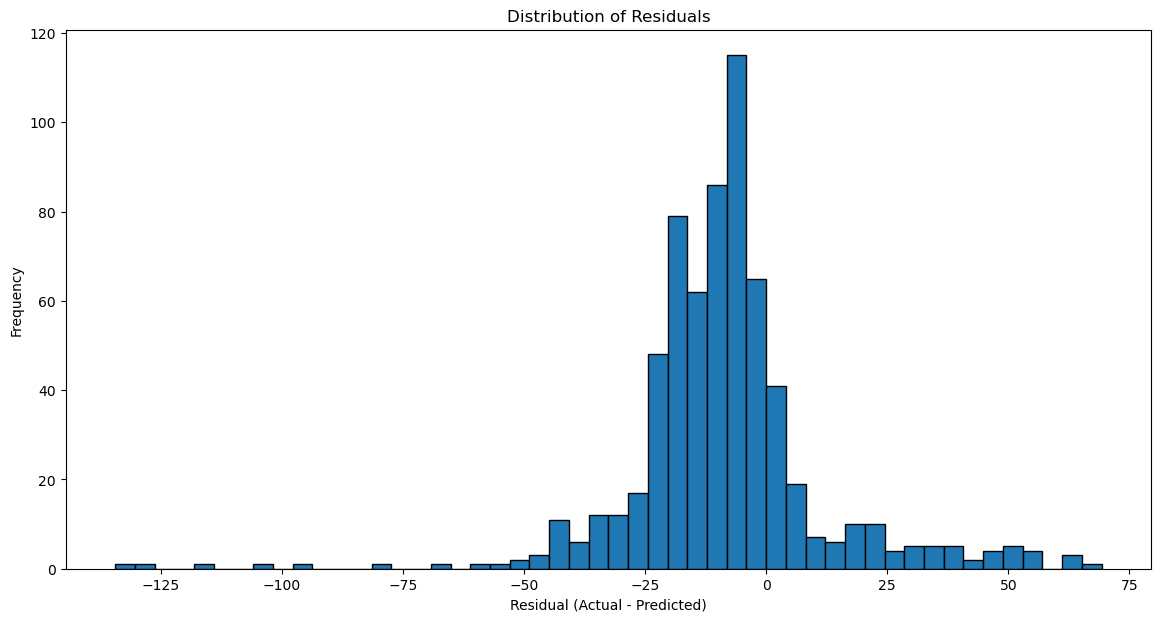

In [63]:
# Plotting residuals
residuals_2 = y_test_inv_2 - y_pred_inv_2
plt.figure(figsize=(14, 7))
plt.hist(residuals_2, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

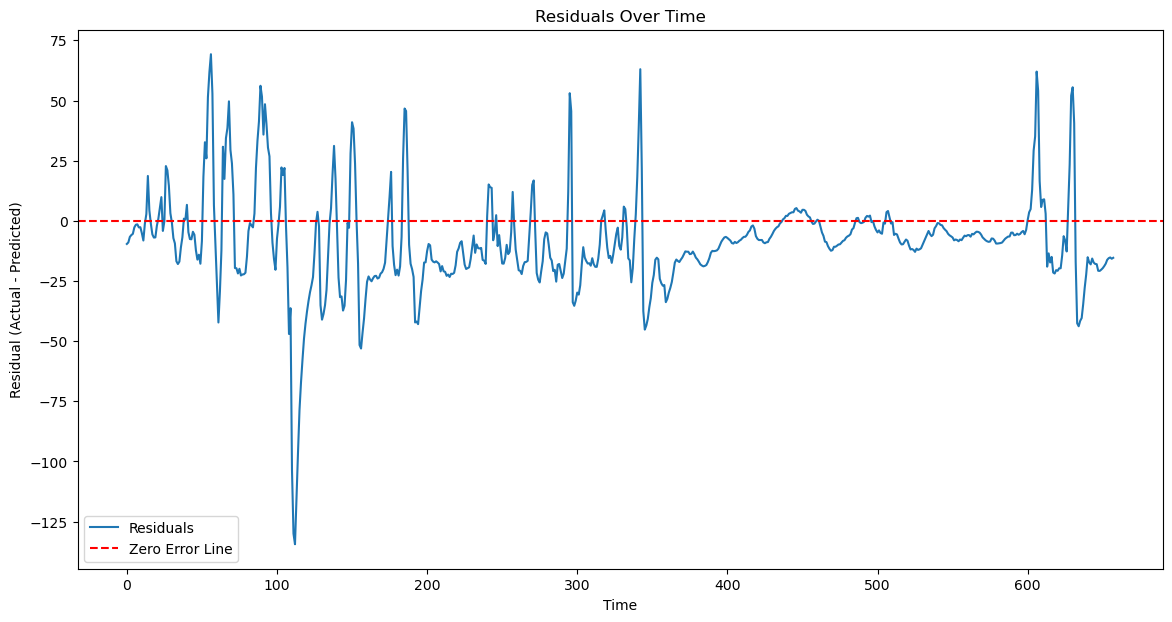

In [64]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_2, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

## 3rd LSTM
3 layers of LSTM

In [65]:
# Three LSTM layers
model3 = Sequential()
# First LSTM layer
model3.add(LSTM(50, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model3.add(Dropout(0.2)) # Dropout layer. 20% of the neurons are randomly dropped during training to prevent overfitting
# Second LSTM layer
model3.add(LSTM(50, return_sequences=True))
model3.add(Dropout(0.2))
# Third LSTM layer
model3.add(LSTM(50)) # No return_sequences because it is the last layer
model3.add(Dropout(0.2))
# Dense layer
model3.add(Dense(1)) ## output layer, with a single neuron, as we are predicting a single continuous value (the CO2 level)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# Save the initial weights for Model 3
initial_weights_model3 = model3.get_weights()

# Reset the model to its initial state before training
model3.set_weights(initial_weights_model3)

In [67]:
# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error') # lr default = 0.001

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 48, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Training the model with early stopping
history_model3 = model3.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0124 - val_loss: 0.0071
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0042 - val_loss: 0.0025


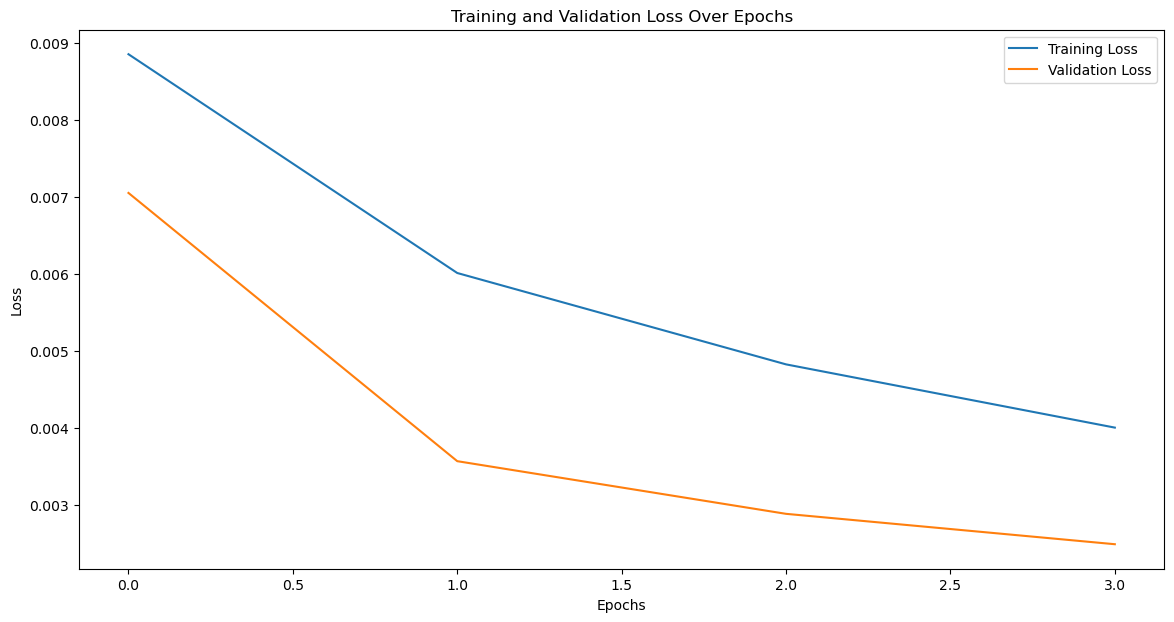

In [69]:
# Extracting loss values 
train_loss_3 = history_model3.history['loss']
val_loss_3 = history_model3.history['val_loss']

# Plotting train and valid loss
plt.figure(figsize=(14, 7))
plt.plot(train_loss_3, label='Training Loss')
plt.plot(val_loss_3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [70]:
# Evaluate the model on the test set
test_loss_3 = model3.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_3}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244
Test Loss: 0.018666621297597885


In [71]:
# Make predictions on the test set
y_pred_3 = model3.predict(X_test)

# Inverse transform predictions and actual values to their original scale
y_pred_inv_3 = scaler.inverse_transform(np.concatenate((y_pred_3, np.zeros((y_pred_3.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]
y_test_inv_3 = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], merged_data_scaled.shape[1] - 1))), axis=1))[:, 0]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


### Evaluation

In [72]:
# Calculate evaluation metrics
mse_3 = mean_squared_error(y_test_inv_3, y_pred_inv_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test_inv_3, y_pred_inv_3)
mae_3 = mean_absolute_error(y_test_inv_3, y_pred_inv_3)

print(f'Mean Squared Error (MSE): {mse_3}')
print(f'Root Mean Squared Error (RMSE): {rmse_3}')
print(f'R-squared (R^2): {r2_3}')
print(f'Mean Absolute Error (MAE): {mae_3}')

Mean Squared Error (MSE): 1125.9585368909773
Root Mean Squared Error (RMSE): 33.55530564442793
R-squared (R^2): 0.09161186581210934
Mean Absolute Error (MAE): 25.26714505267002


R**2 has decreased significantly meaning the model is too complex to generalize the data well

#### Plots

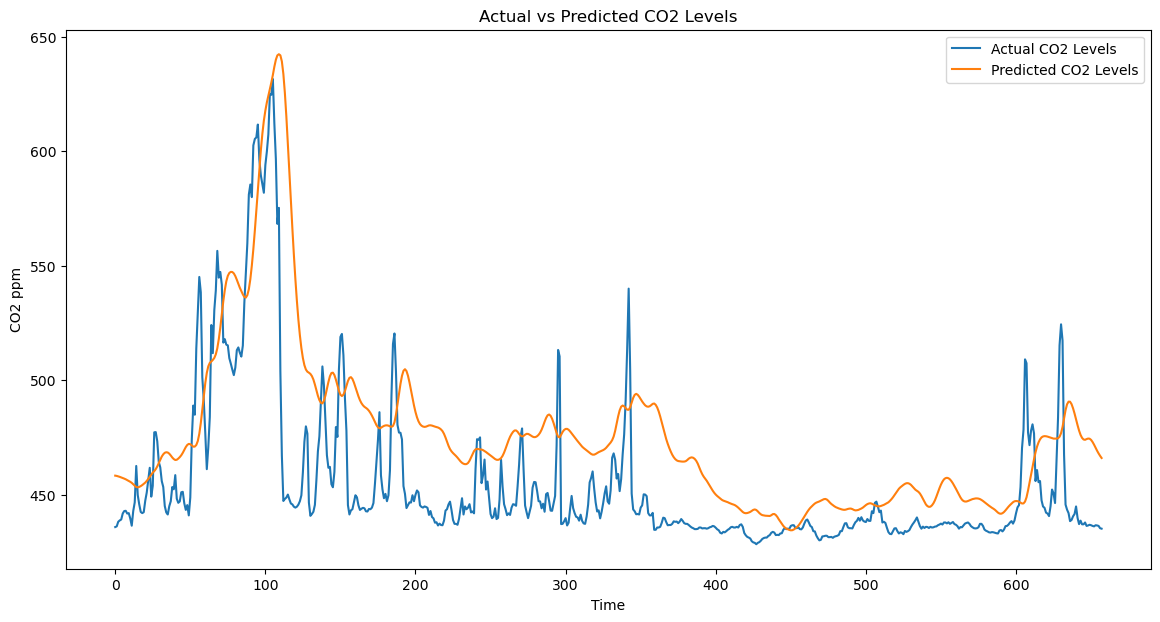

In [73]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv_3, label='Actual CO2 Levels')
plt.plot(y_pred_inv_3, label='Predicted CO2 Levels') # alpha for transparency
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

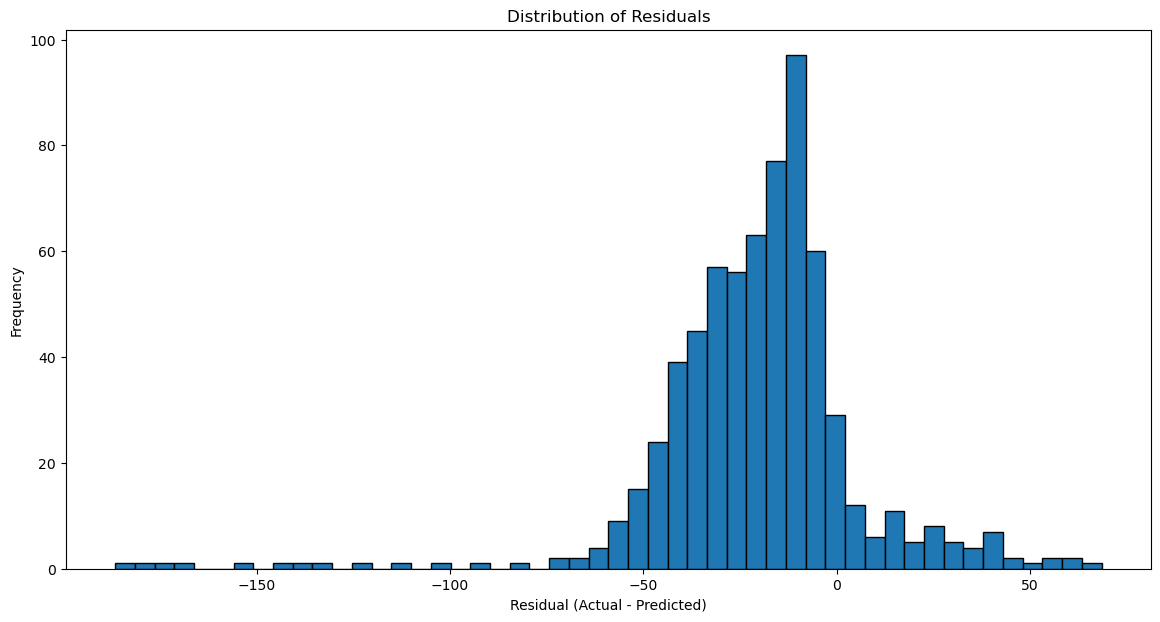

In [74]:
# Plotting residuals
residuals_3 = y_test_inv_3 - y_pred_inv_3
plt.figure(figsize=(14, 7))
plt.hist(residuals_3, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

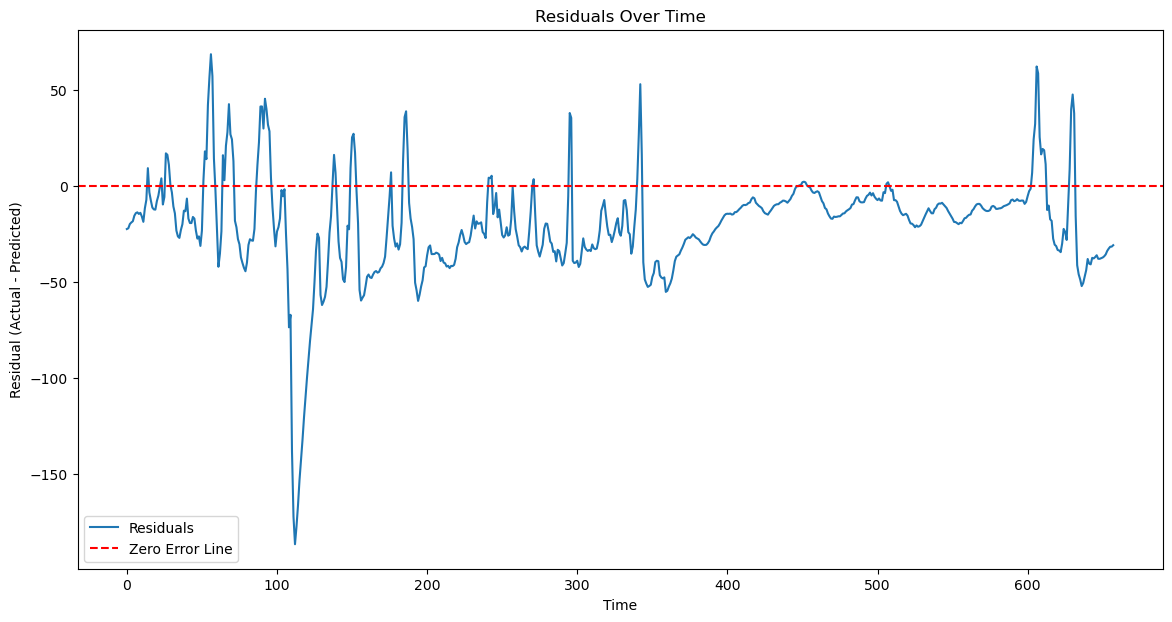

In [75]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals_3, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

## Comparing the Models

     Model          MSE       RMSE        R²        MAE
0  Model 1    80.295553   8.960779  0.935220   5.297396
1  Model 2   494.011921  22.226379  0.601447  15.900700
2  Model 3  1125.958537  33.555306  0.091612  25.267145


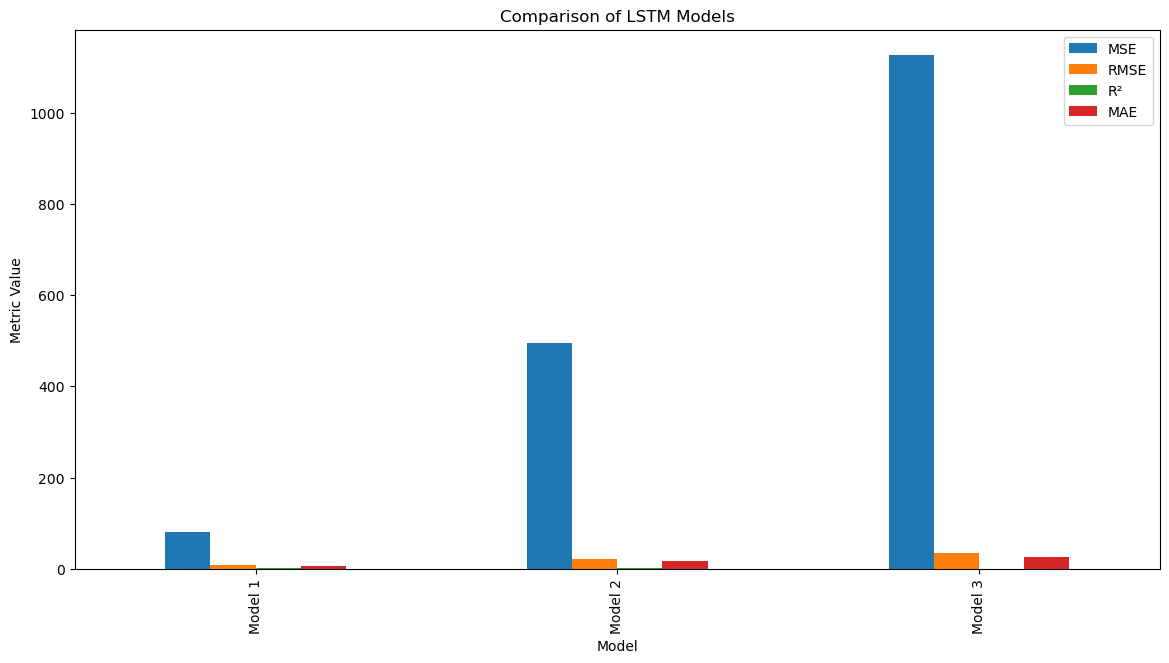

In [76]:
# Gathering the evaluation metrics for all models
metrics = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'MSE': [mse_1, mse_2, mse_3],
    'RMSE': [rmse_1, rmse_2, rmse_3],
    'R²': [r2_1, r2_2, r2_3],
    'MAE': [mae_1, mae_2, mae_3]
}

# Creating a DataFrame to organize the metrics
metrics_df = pd.DataFrame(metrics)

# Displaying the comparison table
print(metrics_df)

# Visualizing the results
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(14, 7), title='Comparison of LSTM Models')
plt.ylabel('Metric Value')
plt.show()

In [77]:
# On the basis of the above results
best_initial_weights = model1.get_weights()

## Fine-Tuning the best model & Hyperparameter Optimisation

Taking the best model from above and performing optimisation to improve the results. 

In [78]:
# Defining the hyperparameter grid
unit_options = [50, 100, 150, 200]
learning_rate_options = [0.01, 0.001, 0.0001]
batch_size = 32

# Storing the best configuration and results
best_val_loss = float('inf')
best_params = {}

# Hyperparameter optimization loop using the pre-trained best model
for units in unit_options:
    for lr in learning_rate_options:
        print(f"Fine-tuning model with units={units}, learning_rate={lr}, batch_size={batch_size}")
        
        # Reset the model to its pre-trained weights to maintain consistency
        model1.set_weights(best_initial_weights)
        
        # Re-compiling the model with the new learning rate
        model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
        
        # Fine-tuning the model (continue training)
        history = model1.fit(X_train, y_train, epochs=10, batch_size=batch_size,
                                validation_data=(X_val, y_val), verbose=1,
                                callbacks=[early_stopping])
        
        # Evaluating the model on the validation data
        val_loss = min(history.history['val_loss'])
        
        # Checking if this is the best model so far
        if val_loss < best_val_loss:
            best_params = {'units': units, 'learning_rate': lr, 'batch_size': batch_size}
            best_lstm_co2xweather_model = tf.keras.models.clone_model(model1)  # Cloning the best model
            best_lstm_co2xweather_model.set_weights(model1.get_weights())  # Copying weights

# Final training on the entire training set with the best hyperparameters
best_lstm_co2xweather_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), 
                           loss='mean_squared_error')

best_lstm_co2xweather_model.fit(X_train, y_train, epochs=10, batch_size=best_params['batch_size'],
              validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

# Final evaluation on the test set with the best fine-tuned model
test_loss = best_lstm_co2xweather_model.evaluate(X_test, y_test)
print(f'Best Fine-tuned Model Test Loss: {test_loss}')
print(f'Best Parameters: {best_params}')

Fine-tuning model with units=50, learning_rate=0.01, batch_size=32
Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9519e-04 - val_loss: 8.1359e-04
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5216e-04 - val_loss: 8.5214e-04
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5554e-04 - val_loss: 8.9402e-04
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6956e-04 - val_loss: 8.6126e-04
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7161e-04 - val_loss: 8.2059e-04
Fine-tuning model with units=50, learning_rate=0.001, batch_size=32
Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7697e-04 - val_loss: 7.9835e-04
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2049e-04 - val_loss: 8.0713e-04
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0960e-04 - val_loss: 8.1934e-04
Epoch 4/10
165/165 ━━━━━━━━

### Evaluation

In [79]:
# Making Predictions with the best fine-tuned model
predictions_best = best_lstm_co2xweather_model.predict(X_test)

# Creating a zero array for padding with the same shape as the original features
zeros = np.zeros((predictions_best.shape[0], merged_data_scaled.shape[1] - 1))

# Concatenating the predictions with zeros to match the original feature shape
predictions_best_with_zeros = np.concatenate([predictions_best, zeros], axis=1)

# Inverse transform to get the original scale
predictions_best_inv = scaler.inverse_transform(predictions_best_with_zeros)[:, 0]  # Only taking the CO2 column

# Inverse transform the actual test values
y_test_actual_best = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), zeros], axis=1))[:, 0]

# Calculating Evaluation Metrics
mse_best = mean_squared_error(y_test_actual_best, predictions_best_inv)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test_actual_best, predictions_best_inv)
mae_best = mean_absolute_error(y_test_actual_best, predictions_best_inv)

print(f'MSE: {mse_best}')
print(f'RMSE: {rmse_best}')
print(f'R Square (R^2): {r2_best}')
print(f'Mean Absolute Error (MAE): {mae_best}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 75.1019057648701
RMSE: 8.666135572726178
R Square (R^2): 0.9394101311758065
Mean Absolute Error (MAE): 4.900752834518284


#### Plots

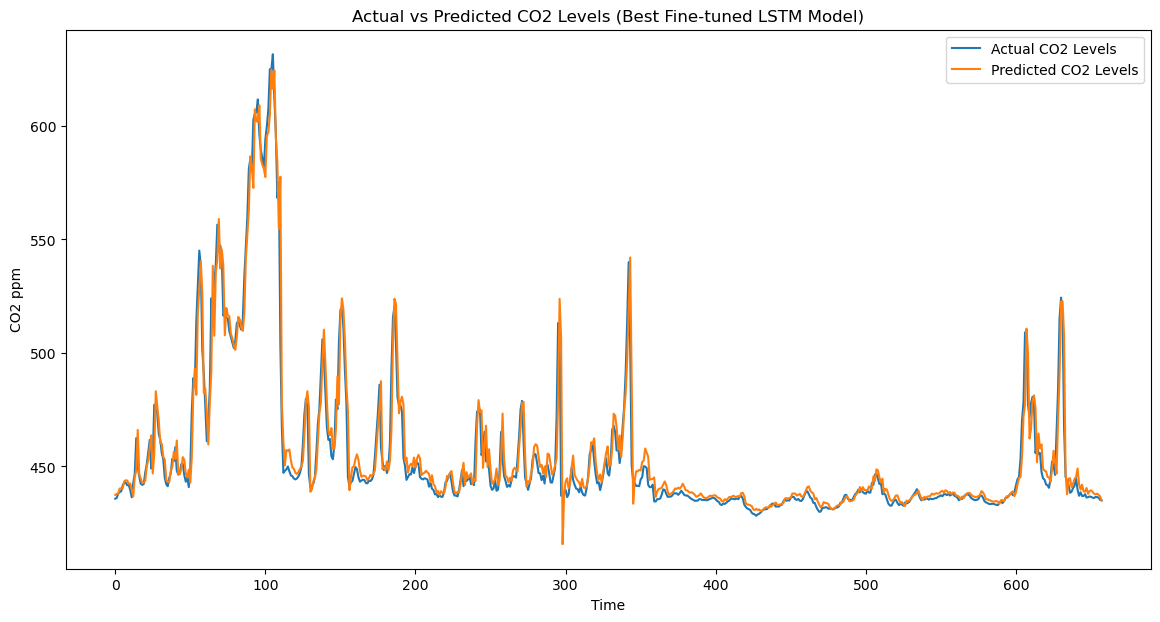

In [80]:
# Plotting predictions vs actual values for the best fine-tuned model
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual_best, label='Actual CO2 Levels')
plt.plot(predictions_best_inv, label='Predicted CO2 Levels')
plt.xlabel('Time')
plt.ylabel('CO2 ppm')
plt.title('Actual vs Predicted CO2 Levels (Best Fine-tuned LSTM Model)')
plt.legend()
plt.show()

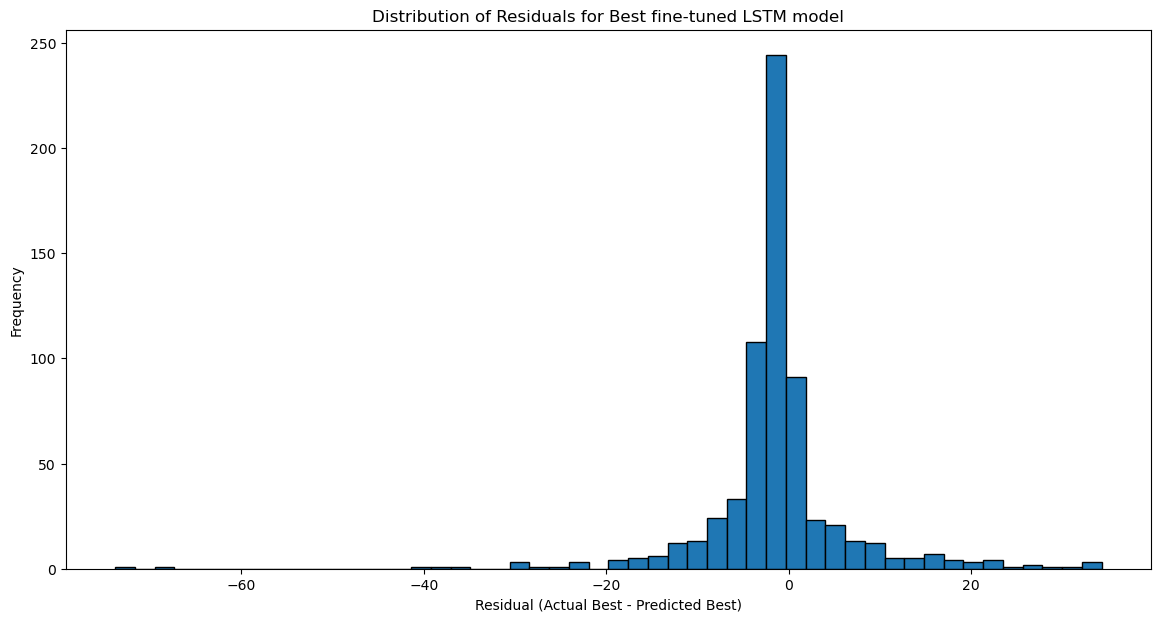

In [81]:
# Plotting residuals
residuals = y_test_actual_best - predictions_best_inv
plt.figure(figsize=(14, 7))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual (Actual Best - Predicted Best)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals for Best fine-tuned LSTM model')
plt.show()

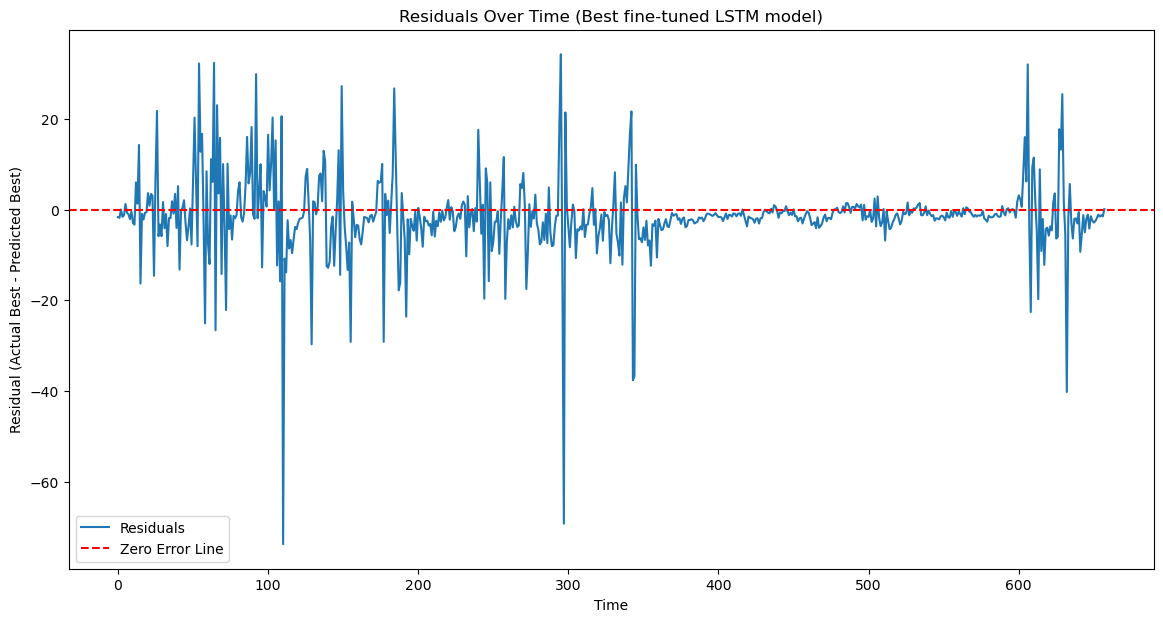

In [82]:
# Plotting residuals over time
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Error Line')
plt.xlabel('Time')
plt.ylabel('Residual (Actual Best - Predicted Best)')
plt.title('Residuals Over Time (Best fine-tuned LSTM model)')
plt.legend()
plt.show()

### Best Model

In [83]:
# Source: https://keras.io/getting_started/faq/
# Saving the best model
model_save_path = "lstm_co2xweather_ap.keras"
best_lstm_co2xweather_model.save(model_save_path)

print(f"Best model saved as {model_save_path}")

Best model saved as lstm_co2xweather_ap.keras
